In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.optim as optim
from torchvision import transforms, utils,datasets
import matplotlib.pyplot as plt
import torchvision

In [2]:
import os
import cv2

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
####DATA_LOADING######
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = datasets.MNIST(root='./data', train=True, transform=trans, download=False)
test_set = datasets.MNIST(root='./data', train=False, transform=trans, download=False)

train_loader = DataLoader(train_set, batch_size=4,shuffle=True)
test_loader = DataLoader(test_set, batch_size=4,shuffle=True)

In [5]:
###GENERATOR###
class generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.noise_to_3d = nn.Linear(100,7*7*256)
        self.block = nn.Sequential(nn.ConvTranspose2d(256,128,kernel_size =3 ,stride=3 ,padding=0),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(),
                                  nn.ConvTranspose2d(128,1,kernel_size =8 ,stride=1 ,padding=0),
                                  nn.BatchNorm2d(1), 
                                  nn.Tanh())
    def forward(self,z):
        out = self.noise_to_3d(z)
        out = out.reshape(out.size(0),256,7,7)
        out = self.block(out)
        return out

In [6]:
####DISCRIMINATOR####
class discriminator(nn.Module):
    def __init__(self):
        super().__init__()
    
        self.layer1 = nn.Sequential(
                                  nn.Conv2d(1,16,kernel_size =7 ,stride=1 ,padding=3),
                                  nn.BatchNorm2d(16),
                                  nn.LeakyReLU(negative_slope=0.2),
                                  nn.MaxPool2d(kernel_size = 2, stride=2))
        self.layer2 = nn.Sequential(
                                  nn.Conv2d(16,32,kernel_size =5 ,stride=1 ,padding=2),
                                  nn.BatchNorm2d(32),
                                  nn.LeakyReLU(negative_slope=0.2),
                                  nn.MaxPool2d(kernel_size =2 , stride=2))
        
        self.fc = nn.Linear(7*7*32,1)
        self.output = nn.Sigmoid()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.output(out)
        return out

In [7]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.detach().numpy()
    plt.imshow((np.transpose(npimg, (1, 2, 0))))
    plt.show()

In [8]:
def noise(size):
    n = torch.randn(size,100)
    return n

In [10]:
gen = generator()
gen = gen.cuda()
dis = discriminator()
dis = dis.cuda()

In [ ]:
criterion  = nn.BCELoss()
optimizer_generator = optim.Adam(gen.parameters(),lr = 0.0002,betas=(0.5,0.999))
optimizer_discriminator = optim.Adam(dis.parameters(),lr = 0.0002,betas=(0.5,0.999))

In [ ]:
############ TRAINING ######################
for epoch in range(1):
    running_total_discriminator_loss  = 0.0
    running_generator_loss = 0.0
    for i,data in enumerate(train_loader,0):
        input_img,l = data
        input_img,l = input_img.cuda(),l.cuda()
        #zero the parameter gradients
        optimizer_discriminator.zero_grad()
        optimizer_generator.zero_grad()
        #forward + loss + backprop#
        
        ###Training discriminator###
    
        real_out = dis(input_img)
        real_loss = criterion(real_out,torch.ones(real_out.shape).cuda())
        Noise = noise(4).cuda()
        fake_image = gen(Noise)
        fake_out = dis(fake_image)
        fake_dis_loss = criterion(fake_out,torch.zeros(fake_out.shape).cuda())
        
        total_discriminator_loss = real_loss + fake_dis_loss
        total_discriminator_loss.backward()
        optimizer_discriminator.step()
       
        ###Training generator###
        Noise = noise(4).cuda()
        fake_image = gen(Noise)
        fake_out = dis(fake_image)
        generator_loss = criterion(fake_out,torch.ones(fake_out.shape).cuda())
        
        generator_loss.backward()
        optimizer_generator.step()
        
         # print statistics
        running_total_discriminator_loss += total_discriminator_loss.item()
        running_generator_loss += generator_loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] dis_loss: %.3f' %
                  (epoch + 1, i + 1, running_total_discriminator_loss / 2000))
            print('[%d, %5d] gen_loss: %.3f' %
                  (epoch + 1, i + 1,running_generator_loss  / 2000))
            running_total_discriminator_loss  = 0.0
            running_generator_loss = 0.0
    
    fake_image = gen(torch.randn(1,100).cuda())
    output = fake_image.cpu()
    imshow(torchvision.utils.make_grid(output))
    #plt.savefig(str(epoch)+".pdf")
    #fake_image = gen(torch.randn(1,100).cuda())    
    #cv2.imwrite(os.path.join('./trained_output', '%05d.png'), get_image(fake_image[0]))
torch.save(dis.state_dict(), 'dis.pth')
torch.save(gen.state_dict(), 'gen.pth')    

In [13]:
################# Evaluation ####################

####### Loading Model #######
gen_eval = generator()
gen_eval = gen_eval.cuda()
dis_eval = discriminator()
dis_eval = dis_eval.cuda()
gen_eval.load_state_dict(torch.load('gen.pth'))
dis_eval.load_state_dict(torch.load('dis.pth'))
gen_eval.eval()
dis_eval.eval()

discriminator(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=1, bias=True)
  (output): Sigmoid()
)

In [20]:
########### Generating Image ###############
fake_image = gen_eval(torch.randn(1,100).cuda())

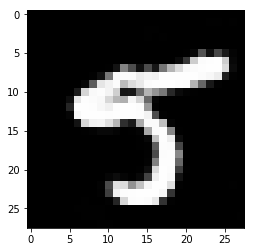

In [21]:
output = fake_image.cpu()
imshow(torchvision.utils.make_grid(output))
#plt.savefig(str(epoch)+".pdf")